In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Bidirectional, LSTM, GRU, Dropout, GlobalAveragePooling1D, Conv1D
     

Data gathering


In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(ds_train, ds_val), ds_info = tfds.load("imdb_reviews", split=["train", "test"], shuffle_files=True, as_supervised=True, with_info=True)
ds_info

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        '

Inspect samples from datasets

Binary classification:

Negative: 0
Positive: 1

In [3]:
sample = next(iter(ds_train))
print("Review:", sample[0].numpy())
print("Label:", sample[1].numpy())
     

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


In [4]:
train_data, train_labels = [], []
for review, label in ds_train:
  train_data.append(str(review.numpy()))
  train_labels.append(label.numpy())

val_data, val_labels = [], []
for review, label in ds_val:
  val_data.append(str(review.numpy()))
  val_labels.append(label.numpy())

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
     

Number of training samples: 25000
Number of validation samples: 25000


Brief analysis to decide proper hparams.



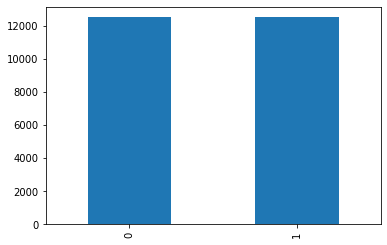

In [5]:
pd.Series(train_labels).value_counts().plot(kind="bar");


In [6]:
pd.Series(train_data).apply(lambda x : len(x.split())).describe()


count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
dtype: float64

In [7]:

BATCH_SIZE = 64
BUFFER_SIZE = 1024
VOCAB_SIZE = 1000
EMBED_DIM = 64
MAX_SEQ_LEN = 256

Featurizing
Tokenizing and padding sequences

The average number of tokens persample is 233. Hence, we choose MAX_SEQ_LEN = 256

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="")
tokenizer.fit_on_texts(train_data)
     

def create_tfds(tokenizer, X, y, padding=False):
  if padding:
    X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_SEQ_LEN, padding="post")
  return tf.data.Dataset.from_tensor_slices((X, y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

ds_train = create_tfds(tokenizer, train_data, train_labels, padding=True)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=True)

Model

In [9]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, input_length=MAX_SEQ_LEN, output_dim=EMBED_DIM))
model.add(Conv1D(filters=64, kernel_size=5, activation="swish"))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           64000     
                                                                 
 conv1d (Conv1D)             (None, 252, 64)           20544     
                                                                 
 dropout (Dropout)           (None, 252, 64)           0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [11]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
     

callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
model.fit(ds_train, epochs=7, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/7
391/391 [==============================] - 42s 105ms/step - loss: 0.4667 - acc: 0.7902 - val_loss: 0.3499 - val_acc: 0.8512
Epoch 2/7
391/391 [==============================] - 44s 112ms/step - loss: 0.3469 - acc: 0.8522 - val_loss: 0.3574 - val_acc: 0.8440
Epoch 3/7
391/391 [==============================] - 40s 101ms/step - loss: 0.3307 - acc: 0.8600 - val_loss: 0.3498 - val_acc: 0.8467
Epoch 4/7
391/391 [==============================] - 40s 101ms/step - loss: 0.3228 - acc: 0.8666 - val_loss: 0.3263 - val_acc: 0.8591
Epoch 5/7
391/391 [==============================] - 40s 102ms/step - loss: 0.3152 - acc: 0.8680 - val_loss: 0.3172 - val_acc: 0.8642
Epoch 6/7
391/391 [==============================] - 40s 102ms/step - loss: 0.3074 - acc: 0.8722 - val_loss: 0.3139 - val_acc: 0.8664
Epoch 7/7
391/391 [==============================] - 41s 104ms/step - loss: 0.3019 - acc: 0.8740 - val_loss: 0.3158 - val_acc: 0.8640


Transfer learning vs. pretrained embedding


In [12]:
ds_train = create_tfds(tokenizer, train_data, train_labels, padding=False)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=False)
     

embedding_url = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 48,190,651
Trainable params: 48,190,651
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
     

callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
model.fit(ds_train, epochs=7, validation_data=ds_val, callbacks=[callbacks]);
     

Epoch 1/7
391/391 [==============================] - 115s 293ms/step - loss: 0.4900 - acc: 0.7735 - val_loss: 0.3541 - val_acc: 0.8617
Epoch 2/7
391/391 [==============================] - 114s 292ms/step - loss: 0.2950 - acc: 0.8830 - val_loss: 0.2841 - val_acc: 0.8836
Epoch 3/7
391/391 [==============================] - 113s 290ms/step - loss: 0.2354 - acc: 0.9064 - val_loss: 0.2664 - val_acc: 0.8904
Epoch 4/7
391/391 [==============================] - 114s 291ms/step - loss: 0.2010 - acc: 0.9228 - val_loss: 0.2611 - val_acc: 0.8923
Epoch 5/7
391/391 [==============================] - 116s 296ms/step - loss: 0.1787 - acc: 0.9326 - val_loss: 0.2615 - val_acc: 0.8915
Epoch 6/7
391/391 [==============================] - 115s 295ms/step - loss: 0.1641 - acc: 0.9390 - val_loss: 0.2648 - val_acc: 0.8916
Epoch 7/7
391/391 [==============================] - 116s 297ms/step - loss: 0.1503 - acc: 0.9445 - val_loss: 0.2727 - val_acc: 0.8901


In [14]:
model.evaluate(ds_val)


391/391 [==============================] - 27s 70ms/step - loss: 0.2727 - acc: 0.8901


[0.2727193236351013, 0.8900799751281738]